##**Proyecto Shark**
Proyecto de analisis de datos enfocado en el torneo de apertura del FPC (semestre 2024 I) para el equipo Junior de Barranquila quien es el actual campeon. El estudio abarcara el analisis del sistema todos contra todos hasta la fecha en la que se encuentren al momento de realizar el analisis con el fin de extraer informacion relevante sobre el desempeño del equipo.

In [ ]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt

###**1. Web Scrapping**

En esta parte del proyecto se traen los datos a usar de la pagina FBREF, se scrapean datos de difrentes direcciones dando como resultado un diccionario con estadisticas por jugador de las 9 primeras fechas y una tabla que muestra el resumen de las fechas del torneo.

In [ ]:
Paginas = ['https://fbref.com/es/partidos/8b1aa4eb/Junior-CA-Bucaramanga-Enero-21-2024-Primera-A',
           'https://fbref.com/es/partidos/d2cde124/Boyaca-Chico-Junior-Enero-28-2024-Primera-A',
           'https://fbref.com/es/partidos/efe5994e/Junior-Independiente-Febrero-1-2024-Primera-A',
           'https://fbref.com/es/partidos/2543afa5/Alianza-Junior-Febrero-4-2024-Primera-A',
           'https://fbref.com/es/partidos/76ab7f4d/Junior-Pasto-Febrero-8-2024-Primera-A',
           'https://fbref.com/es/partidos/4eafa80e/Fortaleza-FC-Junior-Febrero-11-2024-Primera-A',
           'https://fbref.com/es/partidos/c98bb8da/Junior-Tolima-Febrero-18-2024-Primera-A',
           'https://fbref.com/es/partidos/a1c19591/Santa-Fe-Junior-Febrero-21-2024-Primera-A',
           'https://fbref.com/es/partidos/5b65be3d/Deportivo-Pereira-Junior-Febrero-25-2024-Primera-A',
           'https://fbref.com/es/partidos/1cae4951/Junior-Atletico-Nacional-Marzo-2-2024-Primera-A',
           'https://fbref.com/es/partidos/06edca3f/Rionegro-Junior-Marzo-8-2024-Primera-A']


datos = {}

for i in range(len(Paginas)):
  response = requests.get(Paginas[i])
  content = response.text

  soup = BeautifulSoup(content, 'lxml')
  caption_deseado = "Junior Estadísticas de Jugador Table"

  tabla_html = soup.find('caption', string=caption_deseado)
  if tabla_html:
    tabla_html = tabla_html.find_parent('table')
    df = pd.read_html(str(tabla_html))[0]
    df.columns = df.columns.droplevel(0)
    df.drop(df.index[-1], inplace = True)
    datos[f'Fecha {i+1}'] = df

    for j in range(len(df['Edad'])):
      if isinstance(df['Edad'][j],str):

        edad, dias = df['Edad'][j].split('-')
        df.at[j, 'Edad'] = int(edad)
        df.at[j, 'Dias'] = int(dias)

      else:
        pass
    #df.to_csv(f'Fecha {i+1}.csv',index = False, encoding='utf-8-sig')
  else:
    print("No se encontró ninguna tabla con el caption deseado.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
web = 'https://fbref.com/es/comps/41/horario/Resultados-y-partidos-en-Primera-A'
tabla_html = pd.read_html(web)
df = tabla_html[0][tabla_html[0]['Ronda'].notna()]
df = df.reset_index(drop=True)
df.drop('Notas', axis = 1, inplace = True)
datos['Partidos'] = df
#df.to_csv('Partidos.csv',index = False, encoding = 'utf-8-sig')

###**2. Analisis de datos**

####**Analisis General**

In [ ]:
nueva_columna = []
for i in range(len(datos['Partidos']['Marcador'])):
  if type(datos['Partidos']['Marcador'][i]) != float:
    nueva_columna.append(int(datos['Partidos']['Marcador'][i].split('–')[0]))

  else:
    nueva_columna.append(np.nan)

dato = np.array(nueva_columna)
datos['Partidos']['Goles Local'] = dato

In [ ]:
nueva_columna = []
for i in range(len(datos['Partidos']['Marcador'])):
  if type(datos['Partidos']['Marcador'][i]) != float:
    nueva_columna.append(int(datos['Partidos']['Marcador'][i].split('–')[1]))

  else:
    nueva_columna.append(np.nan)

dato = np.array(nueva_columna)
datos['Partidos']['Goles Visitante'] = dato

In [ ]:
puntos_local = []
puntos_visitante = []

for i in range(len(datos['Partidos']['Marcador'])):
  if type(datos['Partidos']['Marcador'][i]) != float:
    if datos['Partidos']['Goles Local'][i] > datos['Partidos']['Goles Visitante'][i]:
        puntos_local.append(3)
        puntos_visitante.append(0)
    elif datos['Partidos']['Goles Local'][i] < datos['Partidos']['Goles Visitante'][i]:
        puntos_local.append(0)
        puntos_visitante.append(3)
    else:
        puntos_local.append(1)
        puntos_visitante.append(1)
  else:
    np.nan

df_temporal = pd.DataFrame({'Puntos Local': puntos_local, 'Puntos Visitante': puntos_visitante})


datos['Partidos'] = pd.concat([datos['Partidos'], df_temporal], axis=1)

####**Estadisticas Generales**

####**Funciones:**

In [ ]:
df = datos['Partidos']

#Partidos Jugados local
def Partidos_Local(equipo):
  PartidosLocal = 0
  for i in range(len(df['Marcador'])):
    if type(df['Marcador'][i]) != float and df['Local'][i] == equipo:
        PartidosLocal += 1
  return PartidosLocal

#Partidos Jugados Visitante
def Partidos_Visitante(equipo):
  PartidosVisitante = 0
  for i in range(len(df['Marcador'])):
    if type(df['Marcador'][i]) != float and df['Visitante'][i] == equipo:
        PartidosVisitante += 1
  return PartidosVisitante

#Partidos Empatados
def Partidos_Empatados(equipo):
  PartidosEmpatados = 0
  for i in range(len(df['Marcador'])):
    if df['Puntos Local'][i] == 1:
      if df['Local'][i] == equipo or df['Visitante'][i] == equipo:
          PartidosEmpatados += 1

  return PartidosEmpatados

#Partidos Ganados
def Partidos_Ganados(equipo):
  PartidosGanados = 0
  PartidosGanadosLocal = 0
  PartidosGanadosVisitante = 0
  for i in range(len(df['Marcador'])):
    if df['Local'][i] == equipo and  df['Puntos Local'][i] == 3:
        PartidosGanados += 1
        PartidosGanadosLocal += 1

    if df['Visitante'][i] == equipo and df['Puntos Visitante'][i] == 3 :
        PartidosGanados += 1
        PartidosGanadosVisitante += 1

  return [PartidosGanados, PartidosGanadosLocal, PartidosGanadosVisitante]

#Goles a Favor
def Goles_Favor(equipo):
  GolesFavor = 0
  GolesFavorLocal = 0
  GolesFavorVisitante = 0
  for i in range(len(df['Marcador'])):
    if type(df['Marcador'][i]) != float:
      if df['Local'][i] == equipo:
        GolesFavor += df['Goles Local'][i]
        GolesFavorLocal += df['Goles Local'][i]

      elif df['Visitante'][i] == equipo:
        GolesFavor += df['Goles Visitante'][i]
        GolesFavorVisitante += df['Goles Visitante'][i]

  return [GolesFavor, GolesFavorLocal, GolesFavorVisitante]

#Goles en Contra
def Goles_Contra(equipo):
  GolesContra = 0
  GolesContraLocal = 0
  GolesContraVisitante = 0
  for i in range(len(df['Marcador'])):
    if type(df['Marcador'][i]) != float:
      if df['Local'][i] == 'Junior':
        GolesContra += df['Goles Visitante'][i]
        GolesContraLocal += df['Goles Visitante'][i]

      if df['Visitante'][i] == 'Junior':
        GolesContra += df['Goles Local'][i]
        GolesContraVisitante += df['Goles Local'][i]

  return [GolesContra, GolesContraLocal, GolesContraVisitante]

#Rendimiento
def Rendimiento(PJ,G,E):
  r = round((((1/3)*E)+G)/PJ,3)
  R = f'{round(r*100,3)} %'
  return [r,R]

#Promedio Gol Local y Visitante
def Promedio_Gol(PL,PV,GL,GV):
  PGL = GL/PL
  PGV = GV/PV
  return [PGL,PGV]



####**Junior de Barranquilla**

In [ ]:
PL = Partidos_Local('Junior')
PV = Partidos_Visitante('Junior')
PJ = PL + PV
G = Partidos_Ganados('Junior')[0]
GL = Partidos_Ganados('Junior')[1]
GV = Partidos_Ganados('Junior')[2]
E = Partidos_Empatados('Junior')
P = PJ-G-E

print(f'Partidos Jugados: {PJ}')
print(f'Partidos Jugados Local: {PL}')
print(f'Partidos Jugados Visitante: {PV}')
print(f'Partidos Ganados: {G}')
print(f'Partidos Perdidos: {P}')
print(f'Partidos Empatados: {E}')

Partidos Jugados: 11
Partidos Jugados Local: 5
Partidos Jugados Visitante: 6
Partidos Ganados: 5
Partidos Perdidos: 3
Partidos Empatados: 3


In [ ]:
GF = Goles_Favor('Junior')[0]
GFL = Goles_Favor('Junior')[1]
GFV = Goles_Favor('Junior')[2]
GC = Goles_Contra('Junior')[0]
GCL = Goles_Contra('Junior')[1]
GCV = Goles_Contra('Junior')[2]
GC
DG = GF-GC

print(f'Goles a Favor: {GF}')
print(f'Goles en Contra: {GC}')
print(f'Diferencia de Gol: {DG}')

Goles a Favor: 15.0
Goles en Contra: 11.0
Diferencia de Gol: 4.0


In [ ]:
R = Rendimiento(PJ,G,E)

print(f'Rendimiento del equipo: {R[1]}\n')

PGFL = Promedio_Gol(PL,PV,GFL,GFV)[0]
PGCL= Promedio_Gol(PL,PV,GCL,GCV)[0]

print(f'Partidos Jugados Local: {PL}')
print(f'Partidos Ganados Local: {GL}')
print(f'Promedio Gol a Favor de Local: {PGFL}')
print(f'Promedio Gol en Contra de Local: {PGCL}\n')

PGFV = Promedio_Gol(PL,PV,GFL,GFV)[1]
PGCV = Promedio_Gol(PL,PV,GCL,GCV)[1]

print(f'Partidos Jugados Visitante: {PV}')
print(f'Partidos Ganados Visitante: {GV}')
print(f'Promedio Gol a Favor de Visitante: {PGFV}')
print(f'Promedio Gol en Contra de Visitante: {PGCV}')

Rendimiento del equipo: 54.5 %

Partidos Jugados Local: 5
Partidos Ganados Local: 3
Promedio Gol a Favor de Local: 1.4
Promedio Gol en Contra de Local: 0.2

Partidos Jugados Visitante: 6
Partidos Ganados Visitante: 2
Promedio Gol a Favor de Visitante: 1.3333333333333333
Promedio Gol en Contra de Visitante: 1.6666666666666667


In [ ]:
df = datos['Partidos']
dfJunior = df[(df['Local'] == 'Junior') | (df['Visitante'] == 'Junior')]
dfJunior = dfJunior.reset_index(drop=True)
dfJunior

,Ronda,Sem.,Día,Fecha,Hora,Local,Marcador,Visitante,Asistencia,Sedes,Árbitro,Informe del partido,Goles Local,Goles Visitante,Puntos Local,Puntos Visitante
0,Apertura — Primera etapa,1.0,Dom,2024-01-21,18:10,Junior,2–0,CA Bucaramanga,NaN,Estadio Metropolitano Roberto Meléndez,Héctor Rivera,Informe del partido,2.0,0.0,3.0,0.0
1,Apertura — Primera etapa,2.0,Dom,2024-01-28,16:00,Boyacá Chicó,2–2,Junior,NaN,Estadio de la Independencia,Diego Ulloa,Informe del partido,2.0,2.0,1.0,1.0
2,Apertura — Primera etapa,3.0,Jue,2024-02-01,20:20,Junior,3–0,Independiente,NaN,Estadio Metropolitano Roberto Meléndez,Luis Delgado,Informe del partido,3.0,0.0,3.0,0.0
3,Apertura — Primera etapa,4.0,Dom,2024-02-04,20:20,Alianza,0–1,Junior,NaN,Estadio Daniel Villa Zapata,Carlos Betancourt,Informe del partido,0.0,1.0,0.0,3.0
4,Apertura — Primera etapa,5.0,Jue,2024-02-08,18:10,Junior,2–0,Pasto,NaN,Estadio Metropolitano Roberto Meléndez,Stiven Camargo,Informe del partido,2.0,0.0,3.0,0.0
5,Apertura — Primera etapa,6.0,Dom,2024-02-11,16:00,Fortaleza FC,2–0,Junior,NaN,Estadio Metropolitano de Techo,Alexander Ortiz,Informe del partido,2.0,0.0,3.0,0.0
6,Apertura — Primera etapa,7.0,Dom,2024-02-18,20:20,Junior,0–1,Tolima,13800.0,Estadio Metropolitano Roberto Meléndez,Nicolás Gallo,Informe del partido,0.0,1.0,0.0,3.0
7,Apertura — Primera etapa,8.0,Mié,2024-02-21,19:45,Santa Fe,3–0,Junior,17491.0,Estadio Nemesio Camacho El Campín,Diego Ruiz,Informe del partido,3.0,0.0,3.0,0.0
8,Apertura — Primera etapa,9.0,Dom,2024-02-25,20:30,Pereira,3–3,Junior,NaN,Estadio Hernán Ramírez Villegas,Andrés Rojas,Informe del partido,3.0,3.0,1.0,1.0
9,Apertura — Primera etapa,10.0,Sáb,2024-03-02,20:20,Junior,0–0,Nacional,25000.0,Estadio Metropolitano Roberto Meléndez,Jorge Duarte,Informe del partido,0.0,0.0,1.0,1.0


puedo hacer grafica barras de puntos local vs puntos visitante, SUMATORIA PTOS POR FECHA, comparacion goles marcados y recibidos por mejores equipos o con mas puntos


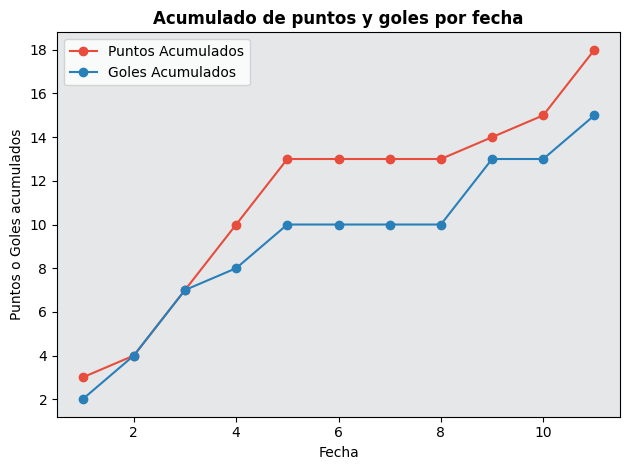

In [ ]:
def sumar_puntos(row):
    if row['Local'] == 'Junior':
        return row['Puntos Local']
    elif row['Visitante'] == 'Junior':
        return row['Puntos Visitante']
    else:
        return 0

def sumar_goles(row):
    if row['Local'] == 'Junior':
        return row['Goles Local']
    elif row['Visitante'] == 'Junior':
        return row['Goles Visitante']
    else:
        return 0

dfJunior['Puntos Total'] = dfJunior.apply(sumar_puntos, axis=1)
dfJunior['Acumulado Puntos'] = dfJunior['Puntos Total'].cumsum()
dfJunior['Goles Total'] = dfJunior.apply(sumar_goles, axis=1)
dfJunior['Acumulado Goles'] = dfJunior['Goles Total'].cumsum()

plt.plot(dfJunior['Sem.'], dfJunior['Acumulado Puntos'], marker='o', linestyle='-', color = '#E74C3C', label = 'Puntos Acumulados')
plt.plot(dfJunior['Sem.'], dfJunior['Acumulado Goles'], marker='o', linestyle='-', color = '#2980B9', label = 'Goles Acumulados')

plt.xlabel('Fecha')
plt.ylabel('Puntos o Goles acumulados')
plt.title('Acumulado de puntos y goles por fecha',fontweight='bold')
plt.legend()
plt.gca().set_facecolor('#E5E7E9')

plt.tight_layout()
plt.show()

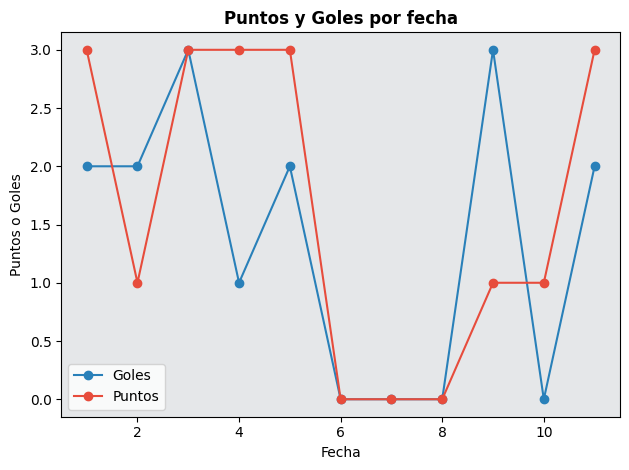

In [ ]:
plt.plot(dfJunior['Sem.'], dfJunior['Goles Total'], marker = 'o', linestyle = '-', color = '#2980B9', label = 'Goles')
plt.plot(dfJunior['Sem.'], dfJunior['Puntos Total'], marker = 'o', linestyle = '-', color = '#E74C3C', label = 'Puntos')

plt.xlabel('Fecha')
plt.ylabel('Puntos o Goles')
plt.title('Puntos y Goles por fecha', fontweight = 'bold')
plt.legend()
plt.gca().set_facecolor('#E5E7E9')

plt.tight_layout()
plt.show()

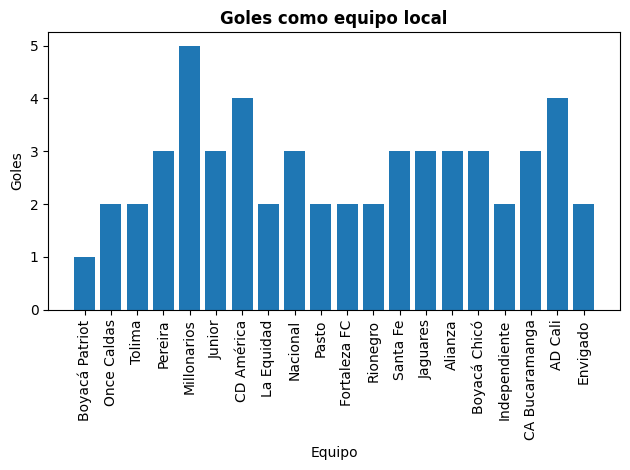

In [ ]:
plt.bar(df['Local'],df['Goles Local'])

plt.xlabel('Equipo')
plt.ylabel('Goles')
plt.title('Goles como equipo local', fontweight = 'bold')

plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

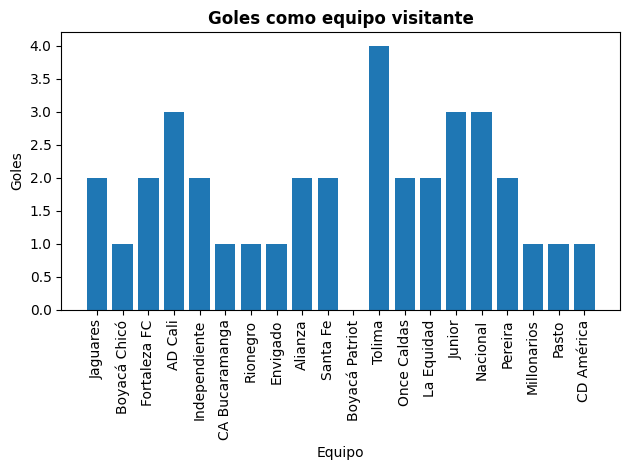

In [ ]:
plt.bar(df['Visitante'],df['Goles Visitante'])

plt.xlabel('Equipo')
plt.ylabel('Goles')
plt.title('Goles como equipo visitante', fontweight = 'bold')

plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

#####**Hallazgo Preliminar**
Teniendo en cuenta hasta la fecha 11:
1. Entre las estadisticas generales resalta, parcialmente, que el equipo mantiene un buen rendimiento jugando como local ganado 3 de 5 partidos, con promedio de gol a favor de 1.4 (siendo minimo de un gol por partido) y promedio de gol en contra de 0.2.

2. Para los partidos jugados como visitante es donde se encuentra el mal rendimiento, ganando solo 2 de 6 partidos y con promedio de gol a fovor y en contra similar.

3. Clave el analisis paar las fechas 5,6,7 y 8.

4. La cantidad de goles anotads como equipo local es baja comparada con los demas equipos.

Debido a los puntos anteriores hay que profundizar en el rendimiento de los partidos a nivel visitante, donde se examinara el rendimiento a nivel de jugadores.